# NIRSpec Prism data analysis I. Finding calibrated data

In this notebook, we will produce corrected data from `uncal` JWST data.

For stage 1 processing, we will mainly use the `jwst` pipeline with some modifications. The main modification is the use of `refpix` step. This dataset does not have reference pixels on three edges of the detector; some earlier works with ERS data have shown that background subtraction at group level works more efficiently than when it is done at integration level. Therefore, we will perform a group level background subtraction using column-by-column background subtraction.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jwst import datamodels
from jwst.pipeline import calwebb_detector1
from stark import reduce
from tqdm import tqdm
import os
import utils
from stark import reduce

2025-03-02 01:23:19,235 - stpipe - WARNING - /Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [2]:
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/Data/NRSPR'
pout = p1 + '/NRSPR/Outputs/Tests'

fname = 'jw01366004001_04101_00001-seg004_nrs1_uncal.fits'

## calwebb detector 1 processing

In [3]:
uncal = datamodels.RampModel(pin + '/' + fname)
nint = np.random.randint(0, uncal.data.shape[0])

print(uncal)

<RampModel(3200, 5, 32, 512) from jw01366004001_04101_00001-seg004_nrs1_uncal.fits>


Meaning that the data has 3200 total integration and 5 groups per integrations. An individual frame has 32 by 512 pixels (32 rows and 512 columns). Let's first visualise the data.

Text(0.5, 1.0, 'Example data')

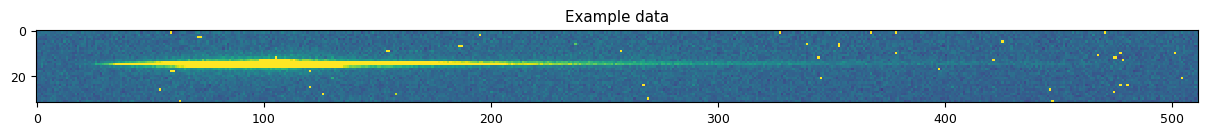

In [4]:
plt.figure(figsize=(15,5))
im = plt.imshow(uncal.data[nint,-1,:,:], interpolation='none')
im.set_clim([0,2e4])
plt.title('Example data')

Let's perform `groupscale`, `dq`, `saturation` and `superbias` steps manually.

In [5]:
groupscale_results = calwebb_detector1.group_scale_step.GroupScaleStep.call(uncal, save_results=False)
dq_results = calwebb_detector1.dq_init_step.DQInitStep.call(groupscale_results, save_results=False)
saturation_results = calwebb_detector1.saturation_step.SaturationStep.call(dq_results, save_results=False)
superbias_results = calwebb_detector1.superbias_step.SuperBiasStep.call(saturation_results, save_results=False)

2025-03-02 01:23:23,217 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/Users/japa6985/opt/anaconda3/envs/jwst/lib/python3.11/site-packages/jwst-1.17.1.dist-info)
2025-03-02 01:23:23,969 - stpipe.GroupScaleStep - INFO - GroupScaleStep instance created.
2025-03-02 01:23:24,033 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep running with args (<RampModel(3200, 5, 32, 512) from jw01366004001_04101_00001-seg004_nrs1_uncal.fits>,).
2025-03-02 01:23:24,034 - stpipe.GroupScaleStep - INFO - Step GroupScaleStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2025-03-02 01:23:24,038 - stpipe.GroupScaleStep - INFO - NFRAMES and FRMDIVSR are equal; correction not needed
2025-03-02 01:23:24,039 - stpipe.GroupScaleStep - INFO - Step will be skipped
2025-03-02 01:23:24,039 - stpipe.GroupSc

Let's look at the counts in one of the rows,

Text(0.5, 1.0, 'Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

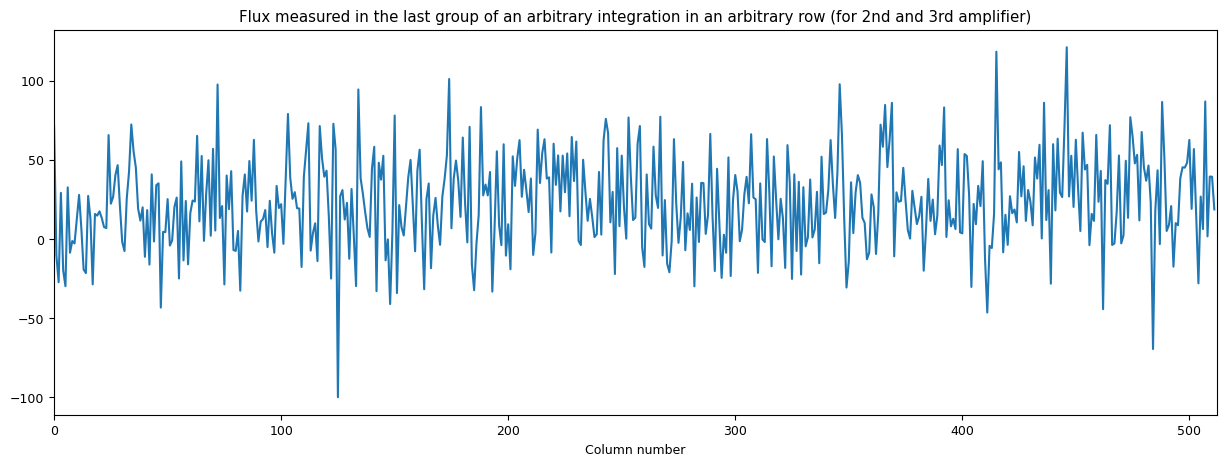

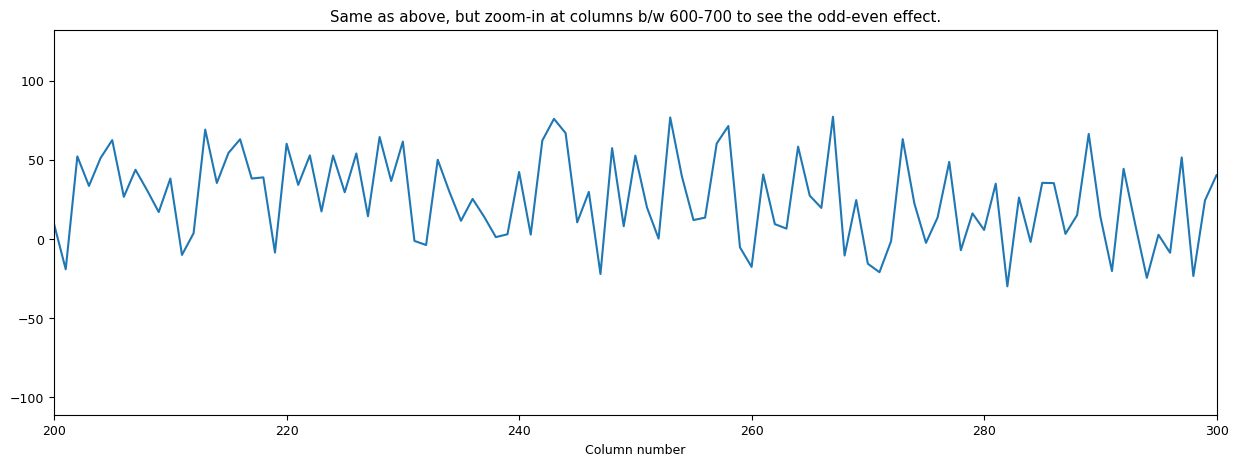

In [6]:
plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,25,:])
#plt.ylim([10250,12750])
plt.xlim([0, 512])
plt.xlabel('Column number')
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

plt.figure(figsize=(15,5))
plt.plot(superbias_results.data[nint,-1,25,:])
#plt.ylim([10250,12250])
plt.xlim([200,300])
plt.xlabel('Column number')
plt.title('Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

I don't think there is any odd-even effect present here! But let's go ahead with the `refpix` correction step anyway and then we will perfrom background subtraction. Since this data doesn't have any real reference pixels, the pipeline will asign top and bottom five pixels as reference pixels and perform the `refpix` step.

In [7]:
refpix_results = calwebb_detector1.refpix_step.RefPixStep.call(superbias_results, save_results=False)

2025-03-02 01:23:40,356 - stpipe.RefPixStep - INFO - RefPixStep instance created.
2025-03-02 01:23:40,453 - stpipe.RefPixStep - INFO - Step RefPixStep running with args (<RampModel(3200, 5, 32, 512) from jw01366004001_04101_00001-seg004_nrs1_uncal.fits>,).
2025-03-02 01:23:40,454 - stpipe.RefPixStep - INFO - Step RefPixStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  odd_even_columns: True
  use_side_ref_pixels: True
  side_smoothing_length: 11
  side_gain: 1.0
  odd_even_rows: True
  ovr_corr_mitigation_ftr: 3.0
  preserve_irs2_refpix: False
  irs2_mean_subtraction: False
  refpix_algorithm: median
  sigreject: 4.0
  gaussmooth: 1.0
  halfwidth: 30
2025-03-02 01:23:41,103 - stpipe.RefPixStep - INFO - Subarray SUB512 has no reference pixels: assigning top and bottom four rows as

And, did it properly correct for odd-even noise?

Text(0.5, 1.0, 'Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

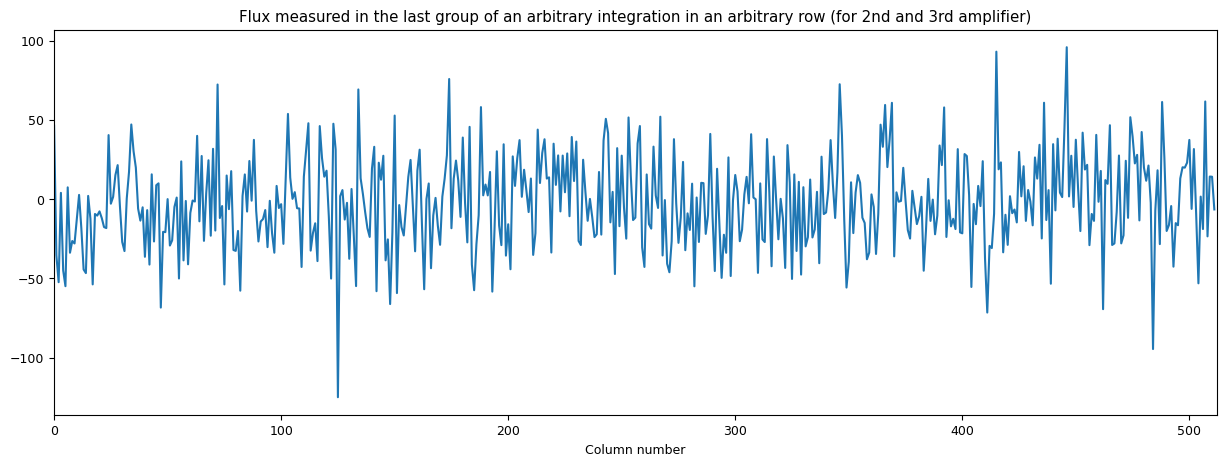

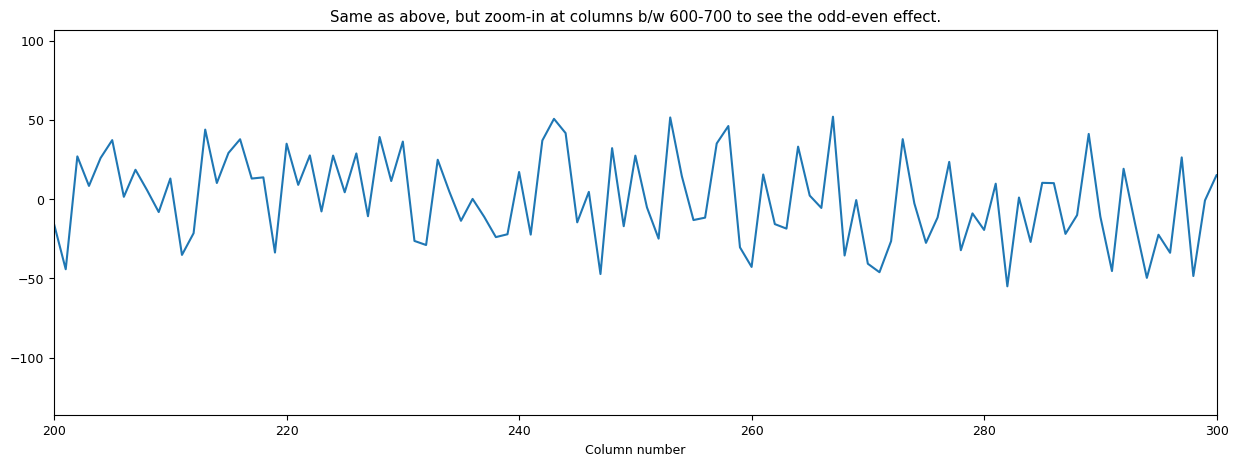

In [8]:
plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,25,:])
#plt.ylim([10250,12750])
plt.xlim([0, 512])
plt.xlabel('Column number')
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row (for 2nd and 3rd amplifier)')

plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,25,:])
#plt.ylim([10250,12250])
plt.xlim([200,300])
plt.xlabel('Column number')
plt.title('Same as above, but zoom-in at columns b/w 600-700 to see the odd-even effect.')

Now, we perform the background subtraction -- we first design a mask for this.

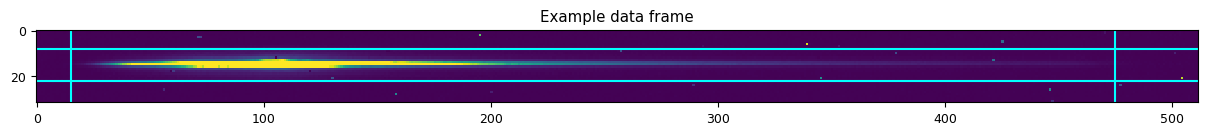

Text(0.5, 1.0, 'Mask (M1)')

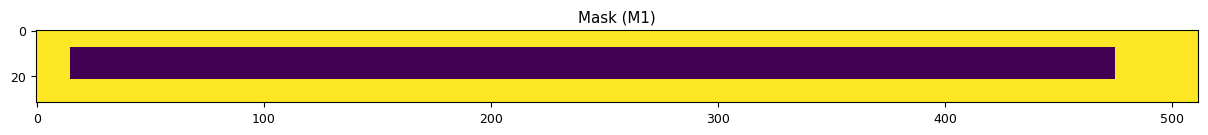

In [9]:
plt.figure(figsize=(15,5))
im = plt.imshow(refpix_results.data[nint,-1,:,:], interpolation='none')
im.set_clim([-100,2e4])
plt.axvline(15, color='cyan')
plt.axvline(475, color='cyan')
plt.axhline(8, color='cyan')
plt.axhline(22, color='cyan')
plt.title('Example data frame')
plt.show()

m1 = np.ones(refpix_results.data[nint,-1,:,:].shape)
m1[8:22,15:475] = 0.

plt.figure(figsize=(15,5))
plt.imshow(m1, interpolation='none')
plt.title('Mask (M1)')

Now, we will perform column-by-column background subtraction. For each column, we will estimate the background by computing median counts along each column. We finally subtract the estimated background from the data.

100%|██████████| 3200/3200 [01:45<00:00, 30.42it/s]


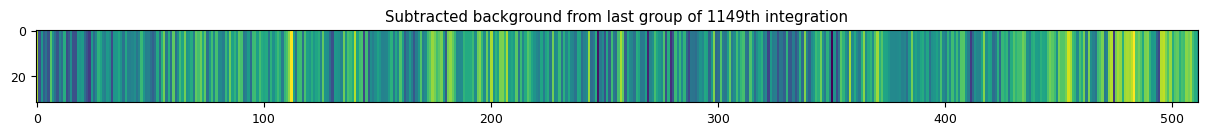

In [10]:
## Column-by-column background subtraction on group level
sub_bkg_col = np.ones(refpix_results.data.shape)
for integration in tqdm(range(refpix_results.data.shape[0])):
    for group in range(refpix_results.data.shape[1]):
        refpix_results.data[integration, group, :, :], sub_bkg_col[integration, group, :, :] =\
            reduce.col_by_col_bkg_sub(frame=refpix_results.data[integration, group, :, :], mask=m1)
        
# Now, let's plot the subtracted background:
plt.figure(figsize=(15,5))
im = plt.imshow(sub_bkg_col[nint,-1,:,:], interpolation='none')
plt.title('Subtracted background from last group of {:d}th integration'.format(nint))
plt.show()

Text(0, 0.5, 'Counts')

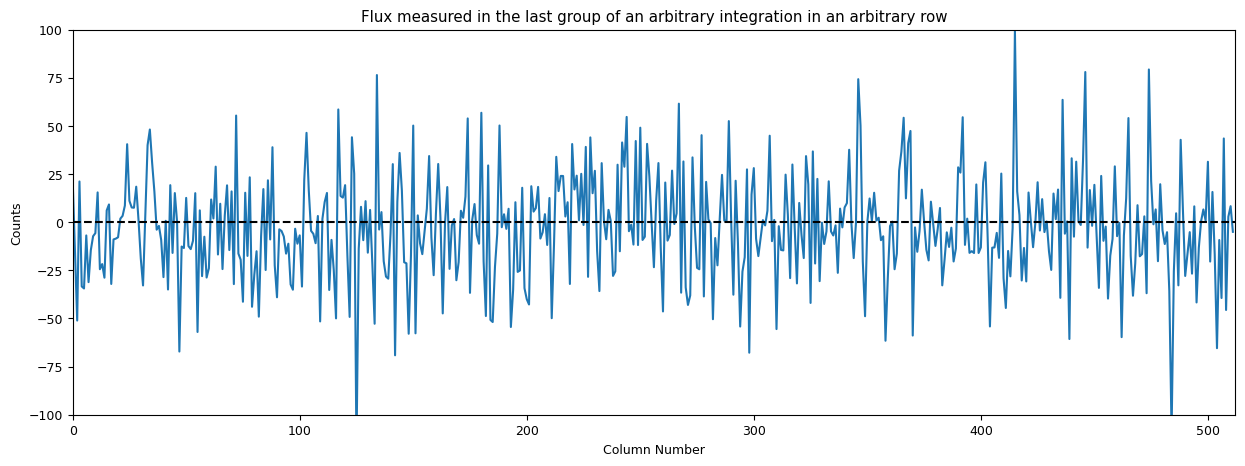

In [11]:
plt.figure(figsize=(15,5))
plt.plot(refpix_results.data[nint,-1,25,:])
plt.axhline(0., color='k', ls='--')
plt.ylim([-100,100])
plt.xlim([0,512])
plt.title('Flux measured in the last group of an arbitrary integration in an arbitrary row')
plt.xlabel('Column Number')
plt.ylabel('Counts')

Awesome! This is a good background subtraction!

Now again continuing with the rest of the steps from the pipeline. We won't perform the jump correction step here, because that step is known to flag many good points as outliers for this dataset.

In [12]:
linearity_results = calwebb_detector1.linearity_step.LinearityStep.call(refpix_results,
                                                                        save_results=False)
darkcurrent_results = calwebb_detector1.dark_current_step.DarkCurrentStep.call(linearity_results,
                                                                            save_results=False)
rampfitting_results = calwebb_detector1.ramp_fit_step.RampFitStep.call(darkcurrent_results, maximum_cores='all',\
                                                                       output_dir=pout, save_results=True)
gainscale_results = calwebb_detector1.gain_scale_step.GainScaleStep.call(rampfitting_results[1],\
                                                                         output_dir=pout, save_results=True)

2025-03-02 01:26:45,835 - stpipe.LinearityStep - INFO - LinearityStep instance created.
2025-03-02 01:26:45,959 - stpipe.LinearityStep - INFO - Step LinearityStep running with args (<RampModel(3200, 5, 32, 512) from jw01366004001_04101_00001-seg004_nrs1_uncal.fits>,).
2025-03-02 01:26:45,960 - stpipe.LinearityStep - INFO - Step LinearityStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: None
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: False
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
2025-03-02 01:26:45,968 - stpipe.LinearityStep - INFO - Using Linearity reference file /Users/japa6985/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0024.fits
2025-03-02 01:26:45,992 - stpipe.LinearityStep - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored
2025-03-02 01:26:48,428 - stpipe.LinearityStep - INFO - Results used CRDS context: jw

Let's look at the mask:

Total per cent of masked points: 3.1943 %


Text(0.5, 1.0, 'Bad-pixels for an arbitrary integration')

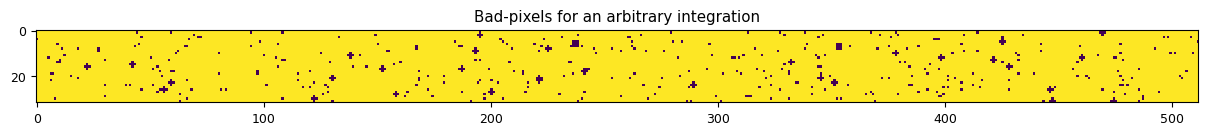

In [13]:
dq = rampfitting_results[1].dq
mask = np.ones(dq.shape)
mask[dq > 0] = 0.

print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask) / (mask.shape[0] * mask.shape[1] * mask.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask[nint,:,:], interpolation='none')
plt.title('Bad-pixels for an arbitrary integration')
#plt.xlim([512,1536])

Okay, so there are about ~3% of pixels are `bad' -- most of them are because of saturation. For example -- the pixels near 100th column are saturated -- so, we will mask them during the spectral extraction.

Text(0.5, 1.0, 'Example data frame')

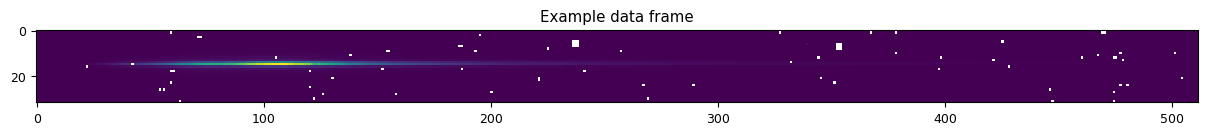

In [14]:
plt.figure(figsize=(15,5))
plt.imshow(gainscale_results.data[nint,:,:], interpolation='none')
plt.title('Example data frame')

Text(0.5, 1.0, 'Flux level in an arbitrary row of an arbitrary integration')

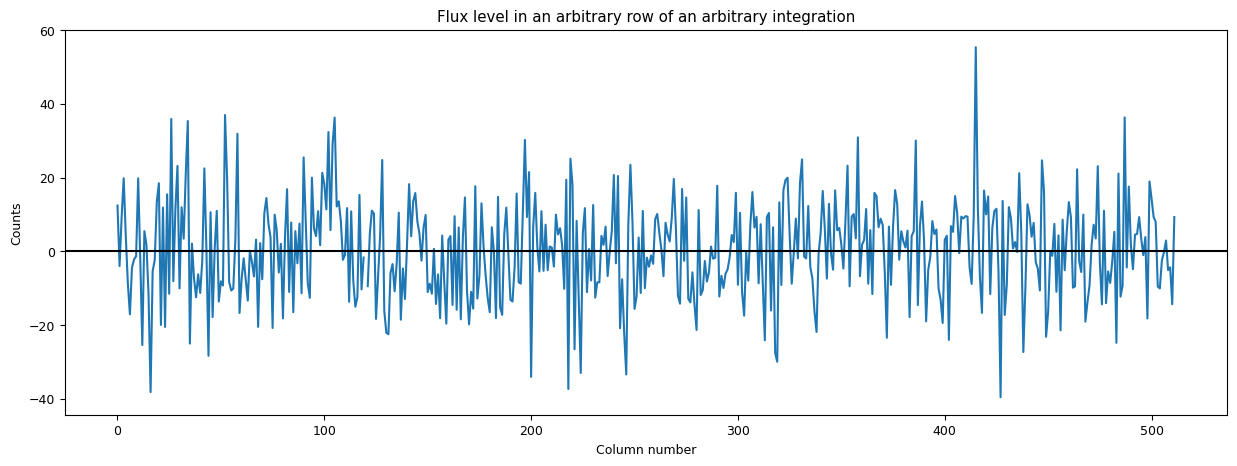

In [15]:
plt.figure(figsize=(15,5))
plt.plot(gainscale_results.data[nint,25,:])
#plt.axvline(1536, color='k')
plt.axhline(0., color='k')
plt.xlabel('Column number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary row of an arbitrary integration')

Text(0.5, 1.0, 'Flux level in an arbitrary column of an arbitrary integration')

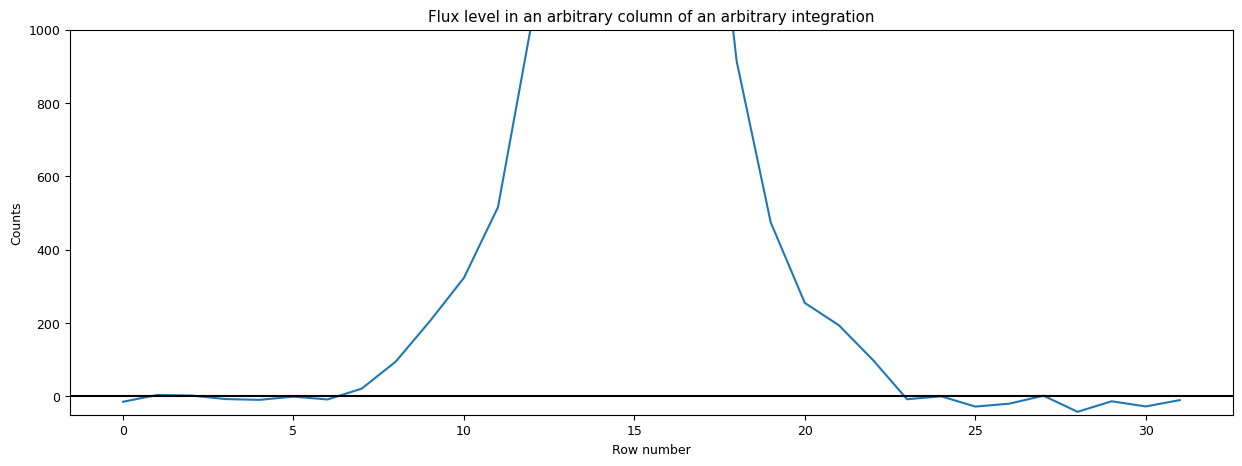

In [16]:
plt.figure(figsize=(15,5))
plt.plot(gainscale_results.data[nint-10,:,50])
plt.ylim([-50,1000])
plt.axhline(0., color='k')
plt.xlabel('Row number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary column of an arbitrary integration')

Maybe, we need to perform another column-by-column background subtraction at the column level.

In [17]:
times_bjd = uncal.int_times['int_mid_BJD_TDB']

print('>>>> --- Correcting errorbars (for zeros and NaNs)...')
## Correct errorbars
med_err = np.nanmedian(gainscale_results.err.flatten())
## Changing Nan's and zeros in error array with median error
corr_err1 = np.copy(gainscale_results.err)
corr_err2 = np.where(gainscale_results.err != 0., corr_err1, med_err)                     # Replacing error == 0 with median error
corrected_errs = np.where(np.isnan(gainscale_results.err) != True, corr_err2, med_err)    # Replacing error == Nan with median error
print('>>>> --- Done!!')

>>>> --- Correcting errorbars (for zeros and NaNs)...
>>>> --- Done!!


And creating a bad-pixel map (this is in addition to the bad-pixel map we already have -- the idea is to include all those pixels with 0 or NaN errors in bad pixel map. Additionally, we will manually identify cosmic rays by comparing median frame with each frame and add those pixels in the bad-pixel map),

In [18]:
print('>>>> --- Creating a bad-pixel map...')
## Making a bad-pixel map
mask_bp1 = np.ones(gainscale_results.data.shape)
mask_bp2 = np.where(gainscale_results.err != 0., mask_bp1, 0.)                 # This will place 0 in mask where errorbar == 0
mask_bp3 = np.where(np.isnan(gainscale_results.err) != True, mask_bp2, 0.)     # This will place 0 in mask where errorbar is Nan
#mask_badpix = np.where(dq == 0., mask_bp3, 0.)                               # This will place 0 in mask where darkdq != 0
mask_badpix = mask * mask_bp3                                                 # Adding those pixels which are identified as bad by the pipeline (and hence 0)

## Mask with cosmic rays
### Essentially this mask will add 0s in the places of bad pixels...
mask_bcr = utils.identify_crays(gainscale_results.data, mask_badpix)
print('>>>> --- Done!!')

>>>> --- Creating a bad-pixel map...
>>>> --- Done!!


Total per cent of masked points: 3.2230 %


Text(0.5, 1.0, 'Bad-pixels for an arbitrary integration')

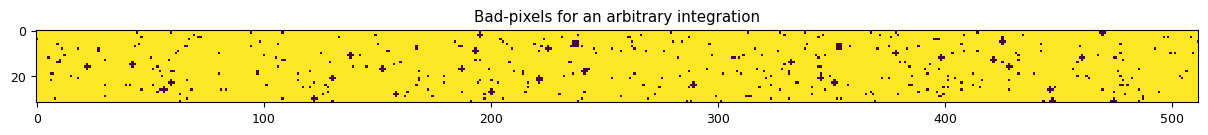

In [19]:
print('Total per cent of masked points: {:.4f} %'.format(100 * (1 - np.sum(mask_bcr) / (mask_bcr.shape[0] * mask_bcr.shape[1] * mask_bcr.shape[2]))))

plt.figure(figsize=(15,5))
plt.imshow(mask_bcr[nint,:,:], interpolation='none')
plt.title('Bad-pixels for an arbitrary integration')
#plt.xlim([512,1536])

And correct the data (meaning replacing NaN values in data-frame with average of neighbouring pixels),

In [20]:
print('>>>> --- Correcting data...')
corrected_data = np.copy(gainscale_results.data)
corrected_data[mask_bcr == 0] = np.nan
for i in range(corrected_data.shape[0]):
    corrected_data[i,:,:] = utils.replace_nan(corrected_data[i,:,:])
print('>>>> --- Done!!')

>>>> --- Correcting data...
>>>> --- Done!!


And, finally, we will perform a row-by-row background subtraction:

In [21]:
corrected_data_bkg = np.ones(corrected_data.shape)
for i in tqdm(range(corrected_data.shape[0])):
    corrected_data_bkg[i,:,:], _ = reduce.col_by_col_bkg_sub(corrected_data[i,:,:], mask=m1*mask_bcr[i,:,:])

100%|██████████| 3200/3200 [00:20<00:00, 153.24it/s]


Text(0, 0.5, 'Counts')

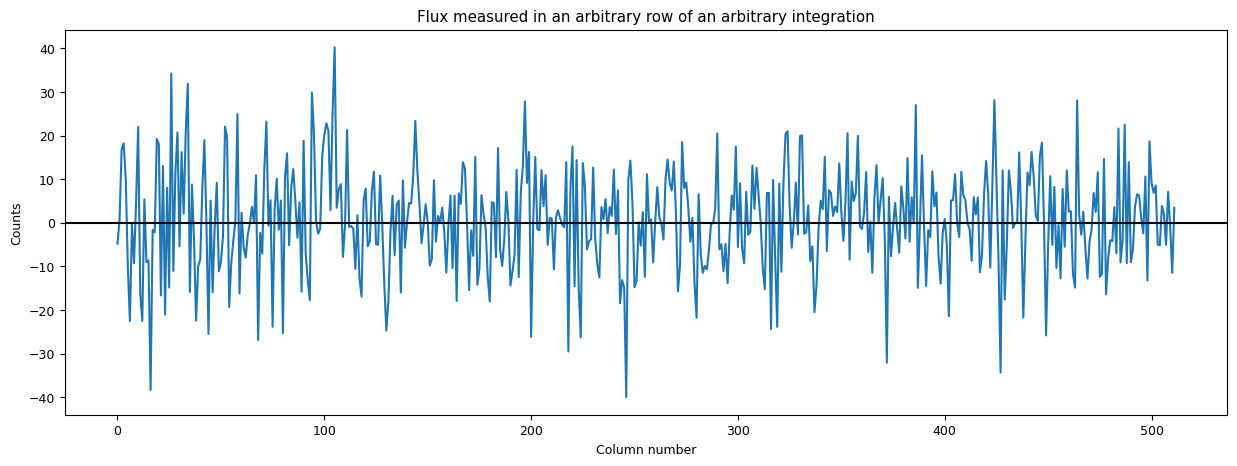

In [22]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg[nint,25,:])
plt.axhline(0., color='k')
plt.title('Flux measured in an arbitrary row of an arbitrary integration')
plt.xlabel('Column number')
plt.ylabel('Counts')

Text(0.5, 1.0, 'Flux level in an arbitrary column of an arbitrary integration')

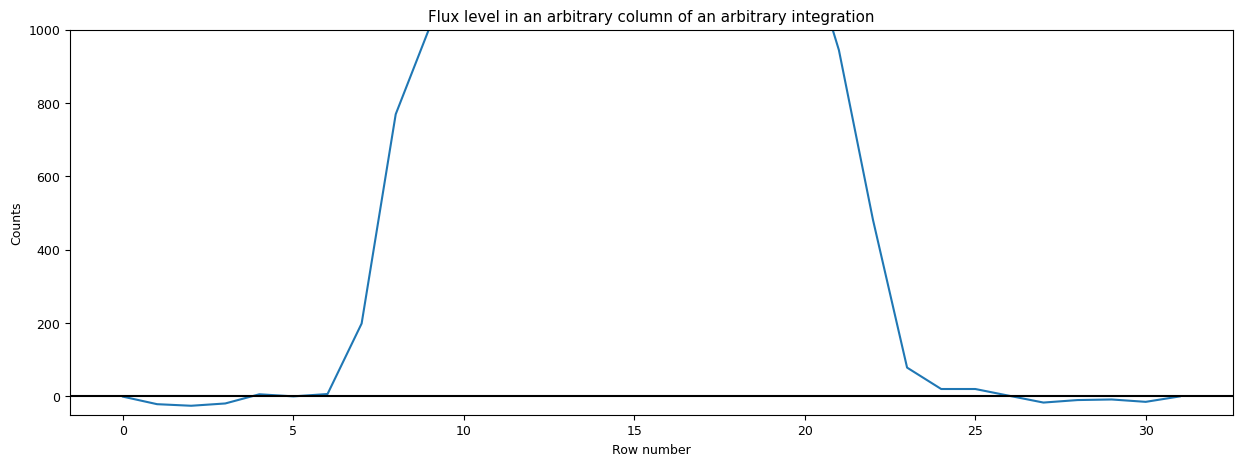

In [23]:
plt.figure(figsize=(15,5))
plt.plot(corrected_data_bkg[nint,:,100])
plt.ylim([-50,1000])
plt.axhline(0., color='k')
plt.xlabel('Row number')
plt.ylabel('Counts')
plt.title('Flux level in an arbitrary column of an arbitrary integration')

Saving the data,

In [24]:
np.save(pout + '/Corrected_data.npy', corrected_data_bkg)
np.save(pout + '/Corrected_err.npy', corrected_errs)
np.save(pout + '/Mask_bcr.npy', mask_bcr)
np.save(pout + '/times.npy', times_bjd)